<div style="text-align:right"><i>Peter Norvig<br>May 2023</div>
    
# Wei-Hwa's Diamond-Buying Game 

[Wei-Hwa Huang](https://en.wikipedia.org/wiki/Wei-Hwa_Huang) poses this puzzle (slightly reworded by me): *You are playing a game where you are buying bags of diamonds with coins.  You can buy a random bag of diamonds for 12 coins, look in the bag to see how many diamonds there are, and immediately decide whether to keep it or sell it back for 11 coins.  You can also peek at as many random bags as you want, for free, to get an idea of the distribution of diamonds. What is a general strategy for maximizing the number of diamonds in the bags you keep?*

## Estimating the Distribution of Bags

A good strategy starts by peeking at multiple bags to form a discrete probability distribution estimate of the number of diamonds per bag. The number of peeks you take will depend on how heavy-tailed you think the distribution might be, and on how much patience you have. 

    
I define `ProbDist` as a class to represent a discrete probability distribution as a dict of `{number_of_diamonds: probability}`. 
    
I also define `normal(σ, μ, k)` to return a `ProbDist` formed from peeking at *k* random samples from a normal distribution with standard deviation σ and mean μ (but limited to non-negative integer values).

In [1]:
from typing import *
import functools
import random
import statistics

random.seed(99)

class ProbDist(Counter):
    """A discrete probability distribution, {item: probability}; sum of probabilities is 1.0"""
    def __init__(self, iterable):
        super().__init__(iterable)
        k = sum(self.values())
        for x in self:
            self[x] /= k
            
def normal(σ=10, μ=100, k=1_000) -> ProbDist: 
    """Probability distribution formed from k samples from a normal distribution,  
    with mean μ and standard deviation σ; each sample is a non-negative integer.""" 
    return ProbDist(max(0, round(random.gauss(sigma=σ, mu=μ))) 
                    for _ in range(k))

assert ProbDist([1, 2, 3, 1]) == {1: 0.5, 2: 0.25, 3: 0.25}

## Maximizing Expected Value

Given a discrete probability distribution, and assuming that our task is to maximize the expected value of the number of diamonds, we can define an optimal strategy that, in each situation, chooses to keep a bag or sell it back based on which action has the highest expected value.

The function `expectation_fn` returns a function `E` such that `E(c)` returns the expected number of diamonds you can obtain starting with `c` coins under the optimal strategy.

In [2]:
def expectation_fn(p:ProbDist, buy=12, sell=11) -> Callable:
    """Returns a function to compute the expected number of diamonds, given `coins`,
    and assuming optimal choices of keep or sell back. The value is 0 if you can't 
    afford a bag, or is the sum, over all bag values, of the probability of the bag 
    times the maximum of the expected value of keeping the bag and the expected value of selling it back."""
    @functools.lru_cache(None)
    def E(coins:int) -> float:
        def keep(bag): return bag + E(coins - buy)
        def sellback(bag): return E(coins - buy + sell)
        if coins < buy:
            return 0
        else:
            return sum(p[bag] * max(keep(bag), sellback(bag)) for bag in p)
    return E

(Note: Why did I define `expectation_fn` to return the function `E`, rather than to do the computation directly? Because, for efficiency, it is critical to use dynamic programming, caching intermediate results rather than recomputing them again and again. And it is not possible to use `lru_cache` on a function with a mutable, unhashable argument such as a `ProbDist`.)

## Examing the Results

Here I define an `E` for a particular probability distribution `p` and call `E(121)`. With 121 coins, I can buy ten bags, and sell back one; the expected result is a little more than 10 times the mean of 100:

In [3]:
p = normal(10)
E = expectation_fn(p)
E(121)

1015.1963478237786

Each run will be slightly different because the random samples are different:

In [4]:
p = normal(10)
E = expectation_fn(p)
E(121)

1015.7985888235405

The expected number of diamonds for 12 coins is about 100; for 13 coins a bit more; for 11 coins it is zero.

In [5]:
E(12)

100.28199999999998

In [6]:
E(13)

104.20628199999996

In [7]:
E(11)

0

## Visualizing the Results

The number of diamonds should increase with the number of coins, and also with the standard deviation of the distribution. Below is a plot showing this:

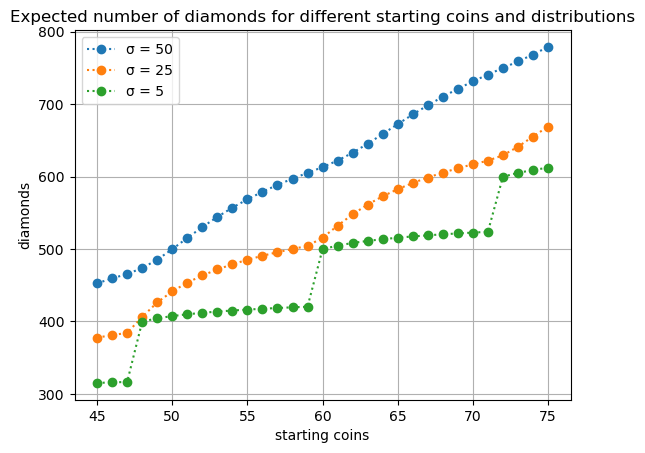

In [8]:
import matplotlib.pyplot as plt

def plot(dist=normal, σs=(50, 25, 5), coins=range(45, 76)):
    """Plot the expected number of diamonds for different (σ, starting coins) combinations."""
    for σ in σs:
        E = expectation_fn(dist(σ))
        vals = [E(c) for c in coins]
        plt.plot(coins, vals, 'o:', label=f'σ = {σ}')
        plt.title('Expected number of diamonds for different starting coins and distributions')
        plt.legend(); plt.xlabel('starting coins'); plt.ylabel('diamonds'); plt.grid(True)

plot()

In this plot, the lowest line, corresponding to a standard deviation of 5, has big jumps when we reach 48, 60, and 72 coins, which corresponds to being able to buy 4, 5, and 6 bags. Basically, for standard deviation 5, the strategy with, say, 48 coins is "buy 4 bags, and keep them, no matter what." For distributions with larger standard deviations, the jump is less pronounced, because the strategy with 48 coins is "if we get 4 good bags, then keep them, but if we get a bad bag at the beginning, sell it back and there is a good chance that a careful selection of 3 bags will result in more diamonds than 4 bags that include the bad one."

Below we see that sampling from a normal distribution is not critical; we get similar-looking results by sampling from a uniform distribution.

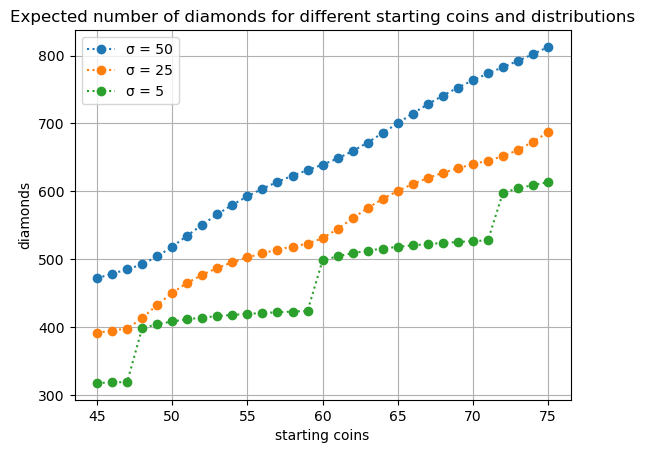

In [9]:
def uniform(w=10, μ=100, k=1_000) -> ProbDist: 
    """Probability distribution formed from k samples from a uniform distribution,  
    with mean μ and width 4w. Each sample is a non-negative integer.""" 
    ints = range(max(0, μ - 2 * w), μ + 2 * w)
    return ProbDist(random.choice(ints) for _ in range(k))

plot(dist=uniform)

# Visualizing the Strategy

Now we know how many diamonds to expect from the optimal strategy, but what **is** the optimal strategy? 

In [10]:
def decision_fn(p:ProbDist, buy=12, sell=11) -> Callable:
    """Return a function, fn(coins, bag), that tells whether to keep or sell back the bag."""
    E = expectation_fn(p, buy, sell)
    return lambda coins, bag: (
        'keep' if bag + E(coins - buy) >= E(coins - buy + sell) else 'sellback')

def scatter(p:ProbDist, coins=range(45, 76)):
    """Plot (coins, bag value) points for which the optimal action is to sell back."""
    fn = decision_fn(p)
    XY = [(c, x) for c in coins for x in range(max(min(p), 70), max(p) + 1) 
          if fn(c, x) == 'sellback']
    X, Y = zip(*XY)
    plt.scatter(X, Y, marker='.'); 
    plt.xlabel('coins'); plt.ylabel('bag value'); plt.grid(True)
    plt.title('Combinations of coins / bag value that should be sold back')

Below is a scatter plot for a distribution with standard deviation of 5, where each dot indicates a situation (the number of coins  and the value of the current bag) where the optimal strategy is to sell the bag back. Each non-dot location means to keep the bag.

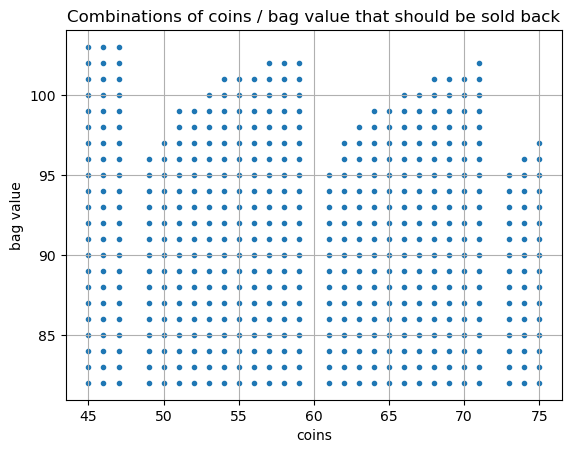

In [11]:
p = normal(5)
scatter(p)

This shows, for example, that with 48 coins there are *no* bag values that should be sold back; it is always better to get 4 bags than to sell one back and be left with only 3 bags. But with each extra coin, we can afford to be more picky, and the bag value that we sell back increases. For example, with 59 coins, we should sell back any bag of 102 diamonds or less. When we get up to 60 coins the best action is to keep all 5 bags.

However, with a larger standard deviation we get a different scatter plot:

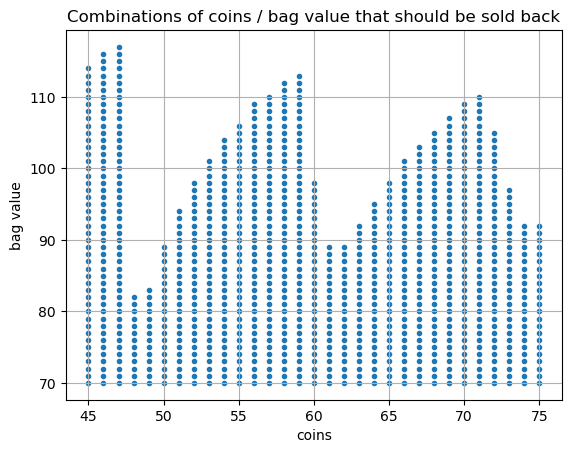

In [12]:
p = normal(25)
scatter(p)

This says that with 48 coins we should sell back a bag of value of 82 or less, even though selling back means we can only get 3 bags instead of 4. The 3 bags will, on average, make up for it, because we can sell back bad ones 11 times. (The exact point at which 'sellback' switches to 'keep' will vary, depending on the samples in the distribution.)

## Cutoff Threshold Strategy

One suggested strategy was to keep all bags that are above a fixed **cutoff threshold** and sell back the rest (except that a bag should be kept if selling it back would not result in enough coins to buy another bag). 

In [13]:
def cutoff_expectation_fn(p:ProbDist, cutoff, buy=12, sell=11) -> Callable:
    """Returns a function to compute the expected number of diamonds, given `coins`,
    assuming we keep all bags with value greater than `cutoff`."""
    @functools.lru_cache(None)
    def Ecut(coins:int) -> float:
        def keep(bag): return bag + Ecut(coins - buy)
        def sellback(bag): return Ecut(coins - buy + sell)
        if coins < buy:
            return 0
        else:
            return sum(p[bag] * (keep(bag) if (bag > cutoff or coins + sell < buy) else sellback(bag))
                       for bag in p)
    return Ecut

def plot_loss(σ=25, coins=range(45, 76), cutoffs=(95, 105, 115)):
    """Plot the expected number of diamonds for different σ/starting coins combinations."""
    p = normal(σ)
    E = expectation_fn(p)
    plt.plot(coins, [E(c) for c in coins], 'o:', label='optimal')
    for cutoff in cutoffs:
        Ecut = cutoff_expectation_fn(p, cutoff)
        plt.plot(coins, [Ecut(c) for c in coins], 'o:', label=f'cutoff = {cutoff}')
        plt.title(f'Expected number of diamonds for different cutoffs, σ={σ}')
        plt.legend(); plt.xlabel('starting coins'); plt.ylabel('diamonds'); plt.grid(True)
      

We see in the plot below that the cutoff strategy is worse than the optimal strategy, for various cutoffs. A good cutoff choice can get within about 5% of optimal:

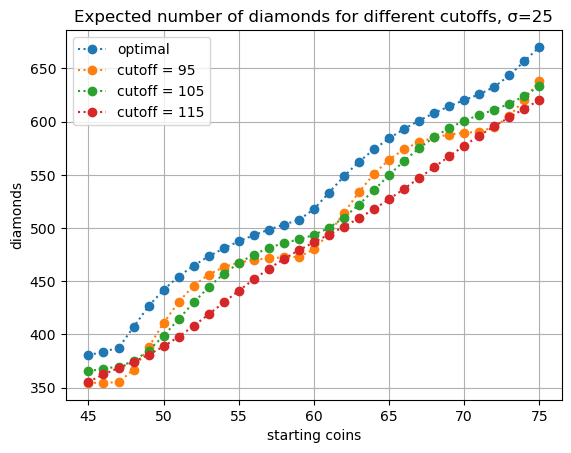

In [14]:
plot_loss(σ=25)

We can check that the optimal strategy is *always* better than a cutoff strategy, as expected:

In [15]:
def optimal_dominates(σs=range(10, 51, 5), cutoffs=range(90, 120), coins=range(200)):
    """Assert that the optimal strategy is always as good or better than a cutoff
    strategy, for a wide range of σ, coins, and cutoff values."""
    for σ in σs:
        p = normal(σ)
        E = expectation_fn(p)
        for cutoff in cutoffs:
            Ecut = cutoff_expectation_fn(p, cutoff)
            assert all(E(coin) >= Ecut(coin) for coin in coins)
        return True
            
optimal_dominates()

True